# Comparing Expressibility and Entangling Capacity for various PQCs

## Calculating Expressibilty

**Step 1:** Choose the _parameterized circuit_    
**Step 2:** Create two sets of random parameters extracted from a uniform distribution and find the corresponding _two random states_   
**Step 3:** Find the fidelity of these two states    
**Step 4:** Repeat the whole process 5000 times (varies with change in width and type of PQC)    
**Step 5:** Discretize this continuous distribution of fidelities    
**Step 6:** Find the KL divergence between this distribution and the distribution of Haar states. This value of KL divergence is the required *Expressibility*

### Creating the Parameterised Quantum Circuit

In [12]:
import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA

from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit.aqua.components.variational_forms import VariationalForm
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import state_fidelity, random_statevector, hellinger_fidelity

from IPython.display import clear_output
from scipy.stats import entropy

### Defining PQC1

In [13]:
def pqc_1(num_qubits=3, reps=1):
    num_qubits = num_qubits            
    reps = reps             # number of times you'd want to repeat the circuit

    num_params = int(reps*(num_qubits + 2*((num_qubits*(num_qubits - 1))/2)))
    x = ParameterVector('x', length=num_params)  # creating a list of Parameters
    variational_form = QuantumCircuit(num_qubits)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)

        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                variational_form.cx(i, j)
                num = num + 1
                variational_form.u1(x[num], i)
                num = num + 1
                variational_form.u1(x[num], j)
                variational_form.cx(i, j)
    return variational_form

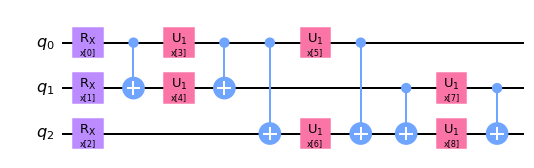

In [14]:
a = pqc_1()
a.draw(output="mpl")

### Defining PQC2 

In [15]:
def pqc_2(num_qubits=3, reps=1):
    num_qubits = num_qubits            
    reps = reps
    num_params = int(reps*(num_qubits + 3*((num_qubits*(num_qubits - 1))/2)))
    x = ParameterVector('y', length=num_params)  # creating a list of Parameters
    variational_form = QuantumCircuit(num_qubits)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)

        for i in range(num_qubits):
            for j in range(i + 1, num_qubits):
                num = num + 1
                variational_form.u1(x[num], j)
                variational_form.cx(i, j)
                num = num + 1
                variational_form.u1(x[num], i)
                variational_form.cx(i, j)
                num = num + 1
                variational_form.u1(x[num], j)
    return variational_form

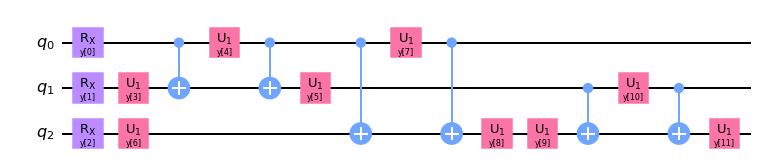

In [16]:
b = pqc_2()
b.draw(output='mpl')

### Function to create Circuit B from the paper

In [17]:
def pqc_test(num_qubits=4, reps=1):
    num_qubits = num_qubits            
    reps = reps
    num_params = int(2*num_qubits*reps)
    x = ParameterVector('z', length=num_params)  # creating a list of Parameters
    variational_form = QuantumCircuit(num_qubits)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.h(i)
            variational_form.rz(x[num], i)
        
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)
    return variational_form

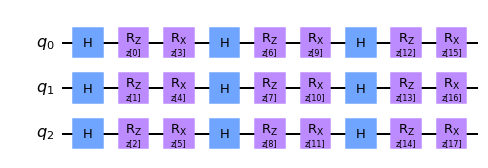

In [18]:
test = pqc_test(num_qubits=3, reps = 3)
test.draw(output='mpl')

## RX RZ

In [19]:
def rx_rz(num_qubits=4, reps=1):
    num_qubits = num_qubits            
    reps = reps
    num_params = int(2*num_qubits*reps)
    x = ParameterVector('a', length=num_params)  # creating a list of Parameters
    variational_form = QuantumCircuit(num_qubits)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)
        
        for i in range(num_qubits):
            num = num + 1
            variational_form.rz(x[num], i)
    return variational_form

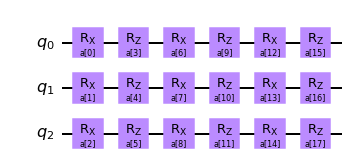

In [20]:
test = rx_rz(num_qubits=3, reps = 3)
test.draw(output='mpl')

In [21]:
def c3(num_qubits=4, reps=1):
    num_qubits = num_qubits            
    reps = reps
    num_params = int(((2*num_qubits) + num_qubits-1)*reps)
    x = ParameterVector('b', length=num_params)  # creating a list of Parameters
    variational_form = QuantumCircuit(num_qubits)

    num = -1
    # defining our parametric form
    for _ in range(reps):
        for i in range(num_qubits):
            num = num + 1
            variational_form.rx(x[num], i)
        
        for i in range(num_qubits):
            num = num + 1
            variational_form.rz(x[num], i)
            
        for i in range(num_qubits-1):
            num = num + 1
            variational_form.crz(x[num], num_qubits-i-1, num_qubits-i-2)
            
    return variational_form

In [22]:
c3().draw()

┌──────────┐┌──────────┐                        ┌───────────┐
q_0: ┤ RX(b[0]) ├┤ RZ(b[4]) ├────────────────────────┤ RZ(b[10]) ├
     ├──────────┤├──────────┤            ┌──────────┐└─────┬─────┘
q_1: ┤ RX(b[1]) ├┤ RZ(b[5]) ├────────────┤ RZ(b[9]) ├──────■──────
     ├──────────┤├──────────┤┌──────────┐└────┬─────┘             
q_2: ┤ RX(b[2]) ├┤ RZ(b[6]) ├┤ RZ(b[8]) ├─────■───────────────────
     ├──────────┤├──────────┤└────┬─────┘                         
q_3: ┤ RX(b[3]) ├┤ RZ(b[7]) ├─────■───────────────────────────────
     └──────────┘└──────────┘

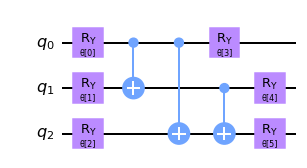

In [37]:
qc_real_ = RealAmplitudes(num_qubits=3, reps=1)
qc_real_.draw(output="mpl")

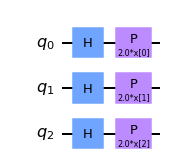

In [42]:
qc5 = ZFeatureMap(feature_dimension=3, reps=1)
qc5.draw(output="mpl")

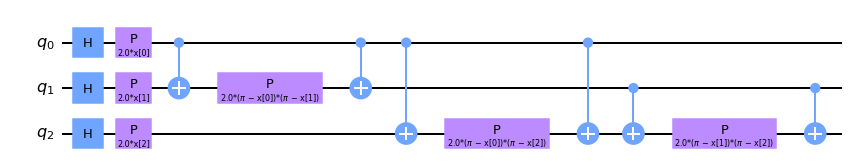

In [43]:
qc5 = ZZFeatureMap(feature_dimension=3, reps=1)
qc5.draw(output="mpl")

## Defining expressibility 

In [23]:
a1 = np.array([1, 2,3, 4, 5])
a1.size

5

In [24]:
print(np.linspace(0,1, 5))

[0.   0.25 0.5  0.75 1.  ]


In [25]:
def prob_dist_haar(num_qubits, bin_num):
    points = np.linspace(0, 1, bin_num + 1) # we are taking one more number than the number of bins so that we can take the average number at each instance for the vvalue at that specific bin 
    haar = []
    const = (2**num_qubits) - 1
    power = const - 1
    for i in range(bin_num):
        haar.append(const*((1 - ((points[i] +points[i+1])/2))**power))
    haar_prob = haar/sum(haar)
#     print(haar_prob)
    return haar_prob

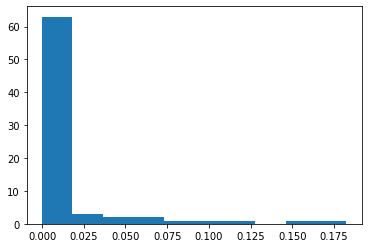

In [26]:
# testing haar prob
dist = prob_dist_haar(4, 75)
plt.hist(dist)
plt.show()

In [27]:
def kl_divergence(a, b):
    """ Compute KL divergence of a || b"""
    a = np.array(a)
    b = np.array(b)
    divergence = 0
    if a.size != b.size:
        print("num of bins of both discrete probability distributions must be same. Size of a is {} and b is {}". format(a.size, b.size))
    else:
        for i in range(a.size):
            divergence = divergence + a[i]*np.log(a[i]/b[i])
    return divergence

In [28]:
def hellinger(dist_a, dist_b):
    fid = 0
    if len(dist_a) != len(dist_b):
        print("Both the distributions must be of same length");
    else:
        dict_a = {}
        dict_b = {}
        for i in range(len(dist_a)):
            dict_a[i] = dist_a[i]
            dict_b[i] = dist_b[i]
        fid = hellinger_fidelity(dict_a, dict_b)
    return(fid)

In [29]:
def expressibility(pqc, trials=5000, bin_num=75, draw=False):
    num_params = pqc.num_parameters
    set_ = pqc.parameters
    num_qubits = pqc.num_qubits
    r1 = {}
    r2 = {}
    fidelities = []
    bins = []
    trials_by_10 = int(trials/10)
    for j in range(trials):
        if j%trials_by_10==0:
            print("{}% completed".format(int((j/trials_by_10)*10)))
        # for each trial form two arrays of random variables 
        for k in set_:
            r1[k] = 2*np.pi*np.random.rand()
            r2[k] = 2*np.pi*np.random.rand()
        circ_1 = pqc.bind_parameters(r1)
        circ_2 = pqc.bind_parameters(r2)
        backend = Aer.get_backend('statevector_simulator')
        job1 = execute(circ_1, backend)
        job2 = execute(circ_2, backend)
        v1 = job1.result().get_statevector()
        v2 = job2.result().get_statevector()
        fidelity = np.abs(np.dot(np.conjugate(v1), v2))**2
#         fidelity = state_fidelity(v1, v2)
        fidelities.append(fidelity)
    print("Fidelity calculations have been completed.")
    fidelities = np.array(fidelities)
    
    # calculating the probability distribution of haar random state fidelities. 
    # Note: haar_fid is a probability distribution however fidelities is a frequency distribution
    haar_fid = prob_dist_haar(num_qubits=num_qubits, bin_num=bin_num)
    
    # drawing the fidelities 
#     plt.bar(np.linspace(0,1, bin_num), haar_fid)
#     fig, ax = plt.subplots()
    
    n, bins, _ = plt.hist(fidelities, bins=np.linspace(0,1, bin_num+1), alpha = 0.5)
    if draw:  
        plt.plot()
#         plt.axhline(y = trials*(1/bin_num), ls = '--')
        plt.xlabel("Fidelities")
        plt.ylabel("Counts")
        plt.show()
    
#     if num_qubits == 1:
#     # creating fidelities of Haar distribution 
#         haar_fid = np.ones(bin_num)/(bin_num)
#     else:
#         haar_fid = []
#         for i in range(trials):
#             haar1 = random_statevector(2**num_qubits)
#             haar2 = random_statevector(2**num_qubits)
#             haar_fid.append(state_fidelity(haar1, haar2))
#         haar_fid = np.array(haar_fid)
    
    pqc_fidelity_probs = n/trials
#     expressibility = kl_divergence(pqc_fidelity_probs, haar_fid)  # this implementation is unstable 
    expressibility = entropy(pqc_fidelity_probs, haar_fid)
    print("Hellinger fidelity: {}".format(hellinger(pqc_fidelity_probs, haar_fid)))
    print("KL divergence: {}".format(expressibility))
#     clear_output()
    print("Expressibility of the pqc is {}".format(expressibility))
    return expressibility, fidelities, r1, r2

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


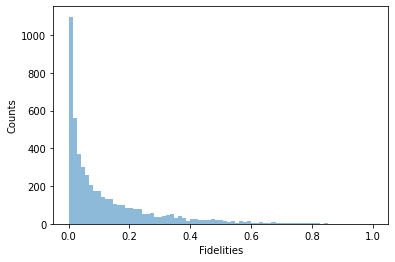

Hellinger fidelity: 0.9361124586609884
KL divergence: 0.15602948884216372
Expressibility of the pqc is 0.15602948884216372


In [30]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_1(num_qubits=3,reps=1), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


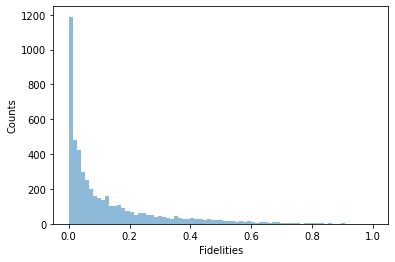

Hellinger fidelity: 0.9171396159629125
KL divergence: 0.2103084232078138
Expressibility of the pqc is 0.2103084232078138


In [31]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_2(num_qubits=3,reps=1), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


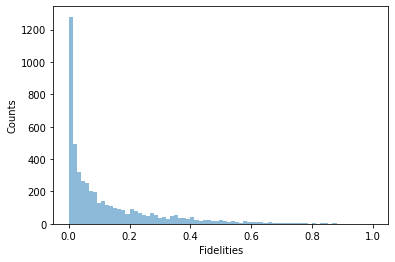

Hellinger fidelity: 0.9121939247378033
KL divergence: 0.2183213719761844
Expressibility of the pqc is 0.2183213719761844


In [32]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(RealAmplitudes(num_qubits=3,reps=1), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


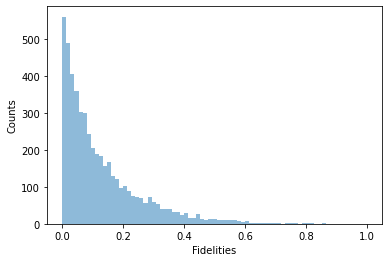

Hellinger fidelity: 0.9905140141167678
KL divergence: 0.02184617123212812
Expressibility of the pqc is 0.02184617123212812


In [33]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_1(num_qubits=3,reps=2), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


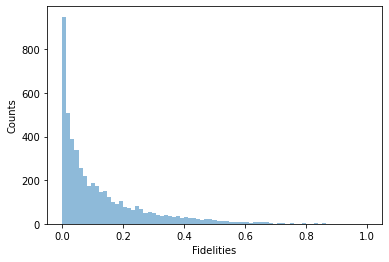

Hellinger fidelity: 0.9558648228583988
KL divergence: 0.1057056931649509
Expressibility of the pqc is 0.1057056931649509


In [34]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_2(num_qubits=3,reps=2), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


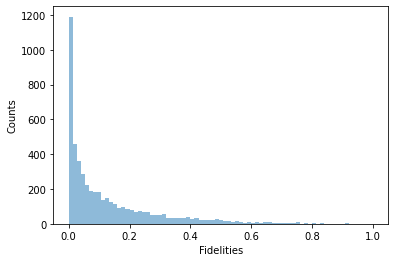

Hellinger fidelity: 0.9282081028161155
KL divergence: 0.1774962271052642
Expressibility of the pqc is 0.1774962271052642


In [35]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(RealAmplitudes(num_qubits=3,reps=2), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


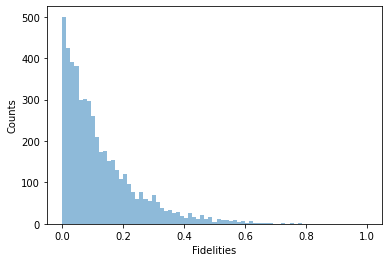

Hellinger fidelity: 0.9943656058890997
KL divergence: 0.012152312825065754
Expressibility of the pqc is 0.012152312825065754


In [38]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_1(num_qubits=3,reps=3), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


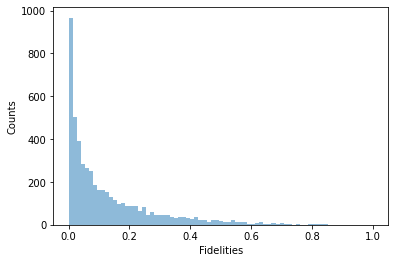

Hellinger fidelity: 0.9499800618907424
KL divergence: 0.12398878269876012
Expressibility of the pqc is 0.12398878269876012


In [39]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_2(num_qubits=3,reps=3), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.


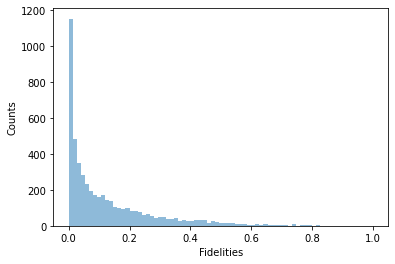

Hellinger fidelity: 0.935317448240912
KL divergence: 0.1548245891194036
Expressibility of the pqc is 0.1548245891194036


In [40]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(RealAmplitudes(num_qubits=3,reps=3), draw=True)


## Expressibility of Test PQC

In [172]:
pqc_test(num_qubits=1, reps=1).draw()

┌───┐┌──────────┐┌──────────┐
q_0: ┤ H ├┤ RZ(z[0]) ├┤ RX(z[1]) ├
     └───┘└──────────┘└──────────┘

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.

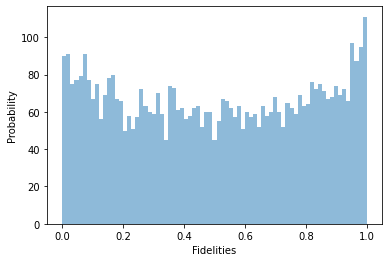

Hellinger fidelity: 0.9377383944486029
KL divergence: 0.015764199359780278
Expressibility of the pqc is 0.015764199359780278


In [173]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_test(num_qubits=1,reps=1), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.

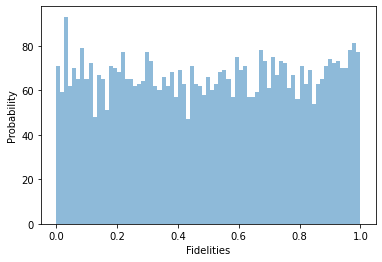

Hellinger fidelity: 0.9590149678581171
KL divergence: 0.006686066092611309
Expressibility of the pqc is 0.006686066092611309


In [174]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_test(num_qubits=1,reps=2), draw=True)


0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.

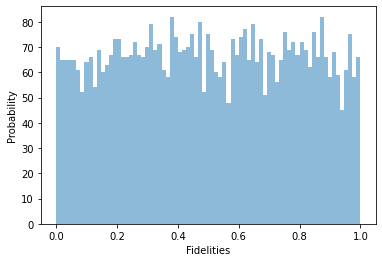

Hellinger fidelity: 0.9591702294348122
KL divergence: 0.006568884447327385
Expressibility of the pqc is 0.006568884447327385


In [175]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_test(num_qubits=1,reps=3), draw=True)



0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.

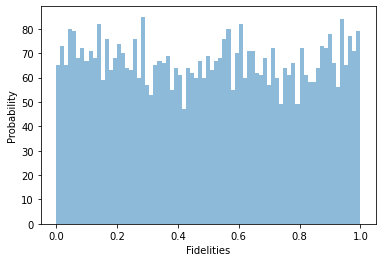

Hellinger fidelity: 0.9560780254594997
KL divergence: 0.007675176205526253
Expressibility of the pqc is 0.007675176205526253


In [176]:
expressibility_test, results_pqc_test_2, pqc_test_r1_2, pqc_test_r2_2 = expressibility(pqc_test(num_qubits=1,reps=4), draw=True)



In [177]:
dict_what = {1:5, 2:10, 3:15}
sum(dict_what.values())
dict_what[4] = 16
dict_what

{1: 5, 2: 10, 3: 15, 4: 16}

**Comparing with the same calcuation in the paper:**

<img src="./img/result-pqc-test.png">

## Unit testing with Circuit 3

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[1.82404553e-01 1.50963030e-01 1.24617762e-01 1.02596475e-01
 8.42355652e-02 6.89660131e-02 5.63009674e-02 4.58248103e-02
 3.71835534e-02 3.00764141e-02 2.42484432e-02 1.94840848e-02
 1.56015626e-02 1.24479971e-02 9.89516639e-03 7.83583670e-03
 6.18059066e-03 4.85509444e-03 3.79774784e-03 2.95766934e-03
 2.29297272e-03 1.76929726e-03 1.35855775e-03 1.03788459e-03
 7.88727803e-04 5.96102086e-04 4.47952739e-04 3.34625005e-04
 2.48421510e-04 1.83234568e-04 1.34241875e-04 9.76556677e-05
 7.05168456e-05 5.05267321e-05 3.59102296e-05 2.53050497e-05
 1.76725032e-05 1.22260341e-05 8.37428927e-06 5.67603153e-06
 3.80465417e-06 2.52043299e-06 1.64897818e-06 1.06462242e-06
 6.77712673e-07 4.24967854e-07 2.62226088e-07 1.59039708e-07
 9.46869421e-08 5.52599366e-08 3.15626193e-08 1.76115641e-08
 9.58082946e-09 5.0697471

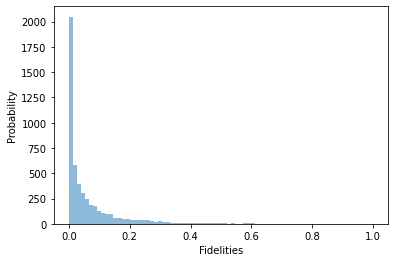

Hellinger fidelity: 0.7748987477946533
KL divergence: 0.2568284467840807
Expressibility of the pqc is 0.2568284467840807


In [82]:
exp_rxrz_2, results_rxrz_2, prxrz_r1_2, rxrz_r2_2 = expressibility(c3(num_qubits=4,reps=1), draw=True)

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[1.82404553e-01 1.50963030e-01 1.24617762e-01 1.02596475e-01
 8.42355652e-02 6.89660131e-02 5.63009674e-02 4.58248103e-02
 3.71835534e-02 3.00764141e-02 2.42484432e-02 1.94840848e-02
 1.56015626e-02 1.24479971e-02 9.89516639e-03 7.83583670e-03
 6.18059066e-03 4.85509444e-03 3.79774784e-03 2.95766934e-03
 2.29297272e-03 1.76929726e-03 1.35855775e-03 1.03788459e-03
 7.88727803e-04 5.96102086e-04 4.47952739e-04 3.34625005e-04
 2.48421510e-04 1.83234568e-04 1.34241875e-04 9.76556677e-05
 7.05168456e-05 5.05267321e-05 3.59102296e-05 2.53050497e-05
 1.76725032e-05 1.22260341e-05 8.37428927e-06 5.67603153e-06
 3.80465417e-06 2.52043299e-06 1.64897818e-06 1.06462242e-06
 6.77712673e-07 4.24967854e-07 2.62226088e-07 1.59039708e-07
 9.46869421e-08 5.52599366e-08 3.15626193e-08 1.76115641e-08
 9.58082946e-09 5.0697471

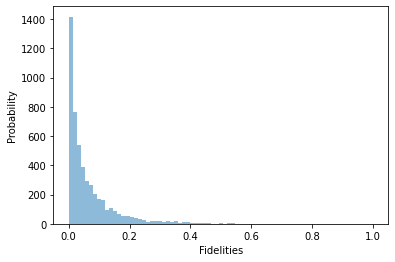

Hellinger fidelity: 0.8721019115385086
KL divergence: 0.08109461893813047
Expressibility of the pqc is 0.08109461893813047


In [83]:
exp_rxrz_2, results_rxrz_2, prxrz_r1_2, rxrz_r2_2 = expressibility(c3(num_qubits=4,reps=2), draw=True)

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[1.82404553e-01 1.50963030e-01 1.24617762e-01 1.02596475e-01
 8.42355652e-02 6.89660131e-02 5.63009674e-02 4.58248103e-02
 3.71835534e-02 3.00764141e-02 2.42484432e-02 1.94840848e-02
 1.56015626e-02 1.24479971e-02 9.89516639e-03 7.83583670e-03
 6.18059066e-03 4.85509444e-03 3.79774784e-03 2.95766934e-03
 2.29297272e-03 1.76929726e-03 1.35855775e-03 1.03788459e-03
 7.88727803e-04 5.96102086e-04 4.47952739e-04 3.34625005e-04
 2.48421510e-04 1.83234568e-04 1.34241875e-04 9.76556677e-05
 7.05168456e-05 5.05267321e-05 3.59102296e-05 2.53050497e-05
 1.76725032e-05 1.22260341e-05 8.37428927e-06 5.67603153e-06
 3.80465417e-06 2.52043299e-06 1.64897818e-06 1.06462242e-06
 6.77712673e-07 4.24967854e-07 2.62226088e-07 1.59039708e-07
 9.46869421e-08 5.52599366e-08 3.15626193e-08 1.76115641e-08
 9.58082946e-09 5.0697471

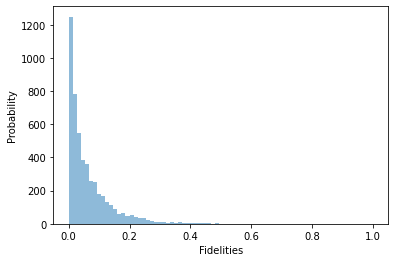

Hellinger fidelity: 0.9098717725492063
KL divergence: 0.03662769932244678
Expressibility of the pqc is 0.03662769932244678


In [84]:
exp_rxrz_2, results_rxrz_2, prxrz_r1_2, rxrz_r2_2 = expressibility(c3(num_qubits=4,reps=3), draw=True)

0% completed
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
Fidelity calculations have been completed.
[1.82404553e-01 1.50963030e-01 1.24617762e-01 1.02596475e-01
 8.42355652e-02 6.89660131e-02 5.63009674e-02 4.58248103e-02
 3.71835534e-02 3.00764141e-02 2.42484432e-02 1.94840848e-02
 1.56015626e-02 1.24479971e-02 9.89516639e-03 7.83583670e-03
 6.18059066e-03 4.85509444e-03 3.79774784e-03 2.95766934e-03
 2.29297272e-03 1.76929726e-03 1.35855775e-03 1.03788459e-03
 7.88727803e-04 5.96102086e-04 4.47952739e-04 3.34625005e-04
 2.48421510e-04 1.83234568e-04 1.34241875e-04 9.76556677e-05
 7.05168456e-05 5.05267321e-05 3.59102296e-05 2.53050497e-05
 1.76725032e-05 1.22260341e-05 8.37428927e-06 5.67603153e-06
 3.80465417e-06 2.52043299e-06 1.64897818e-06 1.06462242e-06
 6.77712673e-07 4.24967854e-07 2.62226088e-07 1.59039708e-07
 9.46869421e-08 5.52599366e-08 3.15626193e-08 1.76115641e-08
 9.58082946e-09 5.0697471

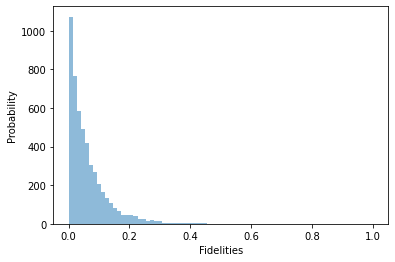

Hellinger fidelity: 0.9504475313701182
KL divergence: 0.01092147362314373
Expressibility of the pqc is 0.01092147362314373


In [85]:
exp_rxrz_2, results_rxrz_2, prxrz_r1_2, rxrz_r2_2 = expressibility(c3(num_qubits=4,reps=6), draw=True)

# Noise testing

In [178]:
from qiskit import IBMQ

In [106]:
IBMQ.save_account('cbfd3b5352ef56ccbe1027324024d95f2ddc458776706e66816161ce159921783233f1ddf9dc2da74f35c42dbc910da209a451c3d79c9ec42346c8f12cc592d5', overwrite=True)


In [179]:
from qiskit.providers.aer import noise
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
noisy_backend = provider.get_backend('ibmq_bogota')
backend_noise = noise.device.basic_device_noise_model(noisy_backend.properties())
print ("Backend Noise Model of Bogota being used")

ibmqfactory.load_account:WARNING:2020-12-08 21:16:46,812: Credentials are already in use. The existing account in the session will be replaced.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:111: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  warnings.warn(


Backend Noise Model of Bogota being used


In [222]:
shots = 5000
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=shots, 
                                   skip_qobj_validation=False,optimization_level=0,
                                   noise_model=backend_noise)

### Testing the circuit 

In [219]:
import time 

In [237]:
qr1 = QuantumRegister(1)
qc1 = QuantumCircuit(qr1)
for i in range(1):
    qc1.h(qr1[0])
#     qc1.h(1)
#     qc1.h(2)
qc1.draw()

┌───┐
q13_0: ┤ H ├
       └───┘

In [207]:
qr1

QuantumRegister(1, 'q')

In [183]:
something = quantum_instance.execute(qc1)

In [184]:
type(results)

qiskit.result.result.Result

In [185]:
job = execute(qc1, Aer.get_backend('qasm_simulator'), shots = 5000)

In [186]:
type(job.result())

qiskit.result.result.Result

In [238]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [239]:
qc_tomo = state_tomography_circuits(qc1, qr1)
qc_tomo[2].draw()

┌───┐ ░ ┌─┐
q13_0: ┤ H ├─░─┤M├
       └───┘ ░ └╥┘
c24_0: ═════════╩═

In [240]:
t = time.time()
tomo_results = quantum_instance.execute(qc_tomo)
print('Time taken:', time.time() - t)

Time taken: 7.7845470905303955


In [245]:
qc_state_density_matrix_noise = StateTomographyFitter(tomo_results, qc_tomo)

In [230]:
# Generate circuits and run on simulator
t = time.time()

# Generate the state tomography circuits.
qst_bell = state_tomography_circuits(bell, [q2[3], q2[5]])

# Execute
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)
print('Time taken:', time.time() - t)

# Fit result
tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)

Time taken: 9.360129117965698


In [234]:
from qiskit import quantum_info as qi
# Perform the tomography fit
# which outputs a density matrix
rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
# F_bell = qi.state_fidelity(rho_fit_bell, target_state_bell)
# print('State Fidelity: F = {:.5f}'.format(F_bell))

In [235]:
rho_fit_bell

array([[ 5.02190817e-01+0.j        ,  9.59877749e-04+0.00556854j,
         1.20658989e-03+0.00253076j,  4.97734400e-01-0.00091392j],
       [ 9.59877749e-04-0.00556854j,  1.13483240e-03+0.j        ,
         1.04625204e-04-0.00109148j, -1.97340443e-04-0.00447071j],
       [ 1.20658989e-03-0.00253076j,  1.04625204e-04+0.00109148j,
         1.11555902e-03+0.j        ,  5.07327125e-05-0.00358869j],
       [ 4.97734400e-01+0.00091392j, -1.97340443e-04+0.00447071j,
         5.07327125e-05+0.00358869j,  4.95558791e-01+0.j        ]])

### Expressibility with Noise

In [ ]:
def expressibility(pqc, trials=5000, bin_num=75, verbose=False, draw=False, quantum_instance=None):
    """ Function that takes in a parameterised quantum circuit and computes its expressibility based on the 
        number of trials and bin number 
        
        Number of trials is set to 5000 by default and number of bins to 75 based on the values given in the 
        paper for 4 qubit PQCs """
    
    # Initialisation 
    r1 = {}
    r2 = {}
    fidelities = []
    bins = []
    
    # Step 1 - Choosing and extracting information about the PQC
    num_params = pqc.num_parameters
    set_ = pqc.parameters
    num_qubits = pqc.num_qubits
    
    # Loop for Steps 2, 3, and 4 
    for j in range(trials):
        if verbose:
            if j%(trials/10)==0:
                print("{}% completed".format(int((j/trials)*100)))
            
        # Step 2 - forming two sets of random parameters for the PQC.
        for k in set_:
            # Creating two sets of random parameter values, each value ranging from 0 to 2*pi. 
            r1[k] = 2*np.pi*np.random.rand()
            r2[k] = 2*np.pi*np.random.rand()
        # Finding the states after applying these quantum circuits to a ground state
        circ_1 = pqc.bind_parameters(r1)
        circ_2 = pqc.bind_parameters(r2)
        backend = Aer.get_backend('statevector_simulator')
        if quantum_instance==None:
            job1 = execute(circ_1, backend)
            job2 = execute(circ_2, backend)
            v1 = job1.result().get_statevector()
            v2 = job2.result().get_statevector()
        else:
            job1 = quantum_instance.execute(circ_1)
            job2 = quantum_instance.execute(circ_2)
            counts1 = job1.get_counts()
            counts2 = job2.get_counts()
            
        
        # Step 3 - Calculate the Fidelity of these two states and store it
        fidelity = state_fidelity(v1, v2)
        fidelities.append(fidelity)
        
    print("Fidelity calculations have been completed.")
    clear_output()
    fidelities = np.array(fidelities)
    
    # Calculating the probability distribution of haar random state fidelities. 
    # Note: haar_fid is a probability distribution however fidelities is a frequency distribution
    haar_fid = prob_dist_haar(num_qubits=num_qubits, bin_num=bin_num)
    
    # Step 5 - plt.hist() automatically discretizes the fidelities frequency distribution and creates bins
    n, bins, _ = plt.hist(fidelities, bins=np.linspace(0,1, bin_num+1), alpha = 0.5)
    if draw:  
        plt.xlabel("Fidelities")
        plt.ylabel("Probability")
        plt.show()
    
    # Step 6 - Find the fidelity between both the states 
    pqc_fidelity_probs = n/trials
    expressibility = entropy(pqc_fidelity_probs, haar_fid)
    print("Expressibility of the pqc using Hellinger fidelity: {}".format(hellinger(pqc_fidelity_probs, haar_fid)))
    print("Expressibility of the pqc using KL divergence: {}".format(expressibility))
    return expressibility, fidelities, r1, r2

# Random Testing

In [141]:
x = np.random.rand(5000)

(array([472., 502., 513., 485., 494., 508., 498., 497., 511., 520.]),
 array([3.09069253e-04, 1.00266208e-01, 2.00223347e-01, 3.00180486e-01,
        4.00137625e-01, 5.00094764e-01, 6.00051902e-01, 7.00009041e-01,
        7.99966180e-01, 8.99923319e-01, 9.99880458e-01]),
 <BarContainer object of 10 artists>)

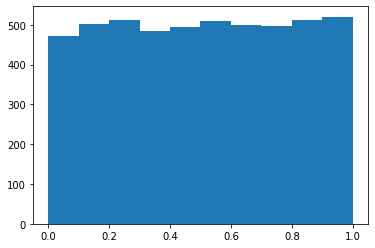

In [142]:
plt.hist(x)

In [60]:
a.num_parameters

16

In [403]:
hello = a.parameters
r1 = {}
r2 = {}
for k in hello:
    r1[k] = 2*np.pi*np.random.rand()
    r2[k] = 2*np.pi*np.random.rand()
r1        

{Parameter(x[2]): 4.381316257931672,
 Parameter(x[7]): 2.5573736500624715,
 Parameter(x[1]): 0.32961223114224675,
 Parameter(x[5]): 0.8426419066868058,
 Parameter(x[0]): 3.2750455569056527,
 Parameter(x[14]): 2.477483724992164,
 Parameter(x[9]): 3.306156017840818,
 Parameter(x[4]): 0.9443658792518793,
 Parameter(x[8]): 2.3357177837643164,
 Parameter(x[10]): 2.596014805832239,
 Parameter(x[11]): 6.219212760210585,
 Parameter(x[6]): 0.01764764053682423,
 Parameter(x[3]): 0.5987498961627724,
 Parameter(x[15]): 1.7933886489679198,
 Parameter(x[12]): 4.714912904512288,
 Parameter(x[13]): 5.20497153495563}

In [404]:
r2

{Parameter(x[2]): 5.988016042924695,
 Parameter(x[7]): 6.0438516812187295,
 Parameter(x[1]): 5.657779113316203,
 Parameter(x[5]): 0.30666187520621313,
 Parameter(x[0]): 1.6982585039199911,
 Parameter(x[14]): 1.6844783020288632,
 Parameter(x[9]): 3.34774650944817,
 Parameter(x[4]): 2.20999089002728,
 Parameter(x[8]): 2.177557447058975,
 Parameter(x[10]): 4.916301616027501,
 Parameter(x[11]): 1.191937441919063,
 Parameter(x[6]): 4.333356714863685,
 Parameter(x[3]): 2.6929293336277307,
 Parameter(x[15]): 0.9742286168720141,
 Parameter(x[12]): 1.4507685793444574,
 Parameter(x[13]): 2.2181805656104077}

In [405]:
m = a.bind_parameters(r2)
m.draw()

┌────────────┐       ┌──────────┐           ┌────────────┐          »
q_0: ┤ RX(1.6983) ├──■────┤ U1(2.21) ├───■────■──┤ U1(4.3334) ├──■────■──»
     ├────────────┤┌─┴─┐┌─┴──────────┴┐┌─┴─┐  │  └────────────┘  │    │  »
q_1: ┤ RX(5.6578) ├┤ X ├┤ U1(0.30666) ├┤ X ├──┼──────────────────┼────┼──»
     ├───────────┬┘└───┘└─────────────┘└───┘┌─┴─┐┌────────────┐┌─┴─┐  │  »
q_2: ┤ RX(5.988) ├──────────────────────────┤ X ├┤ U1(6.0439) ├┤ X ├──┼──»
     ├───────────┴┐                         └───┘└────────────┘└───┘┌─┴─┐»
q_3: ┤ RX(2.6929) ├─────────────────────────────────────────────────┤ X ├»
     └────────────┘                                                 └───┘»
«     ┌────────────┐                                                     »
«q_0: ┤ U1(2.1776) ├────────────────■────────────────────────────────────»
«     └────────────┘┌────────────┐  │            ┌────────────┐          »
«q_1: ──────■───────┤ U1(4.9163) ├──┼────■────■──┤ U1(1.4508) ├──■───────»
«         ┌─┴─┐     ├────────────┤  │  ┌─┴─┐  │  └────────────┘  │       »
«q_2: ────┤ X ├─────┤ U1(1.1919) ├──┼──┤ X ├──┼──────────────────┼────■──»
«     ┌───┴───┴────┐└────────────┘┌─┴─┐└───┘┌─┴─┐┌────────────┐┌─┴─┐┌─┴─┐»
«q_3: ┤ U1(3.3477) ├──────────────┤ X ├─────┤ X ├┤ U1(2.2182) ├┤ X ├┤ X ├»
«     └────────────┘              └───┘     └───┘└────────────┘└───┘└───┘»
«                         
«q_0: ────────────────────
«                         
«q_1: ────────────────────
«      ┌────────────┐     
«q_2: ─┤ U1(1.6845) ├──■──
«     ┌┴────────────┤┌─┴─┐
«q_3: ┤ U1(0.97423) ├┤ X ├
«     └─────────────┘└───┘

In [406]:
l = a.bind_parameters(r1)
l.draw()

┌───────────┐      ┌─────────────┐          ┌──────────────┐          »
q_0: ─┤ RX(3.275) ├───■──┤ U1(0.94437) ├──■────■──┤ U1(0.017648) ├──■────■──»
     ┌┴───────────┴┐┌─┴─┐├─────────────┤┌─┴─┐  │  └──────────────┘  │    │  »
q_1: ┤ RX(0.32961) ├┤ X ├┤ U1(0.84264) ├┤ X ├──┼────────────────────┼────┼──»
     └┬────────────┤└───┘└─────────────┘└───┘┌─┴─┐ ┌────────────┐ ┌─┴─┐  │  »
q_2: ─┤ RX(4.3813) ├─────────────────────────┤ X ├─┤ U1(2.5574) ├─┤ X ├──┼──»
     ┌┴────────────┤                         └───┘ └────────────┘ └───┘┌─┴─┐»
q_3: ┤ RX(0.59875) ├───────────────────────────────────────────────────┤ X ├»
     └─────────────┘                                                   └───┘»
«     ┌────────────┐                                                     »
«q_0: ┤ U1(2.3357) ├────────────────■────────────────────────────────────»
«     └────────────┘┌───────────┐   │            ┌────────────┐          »
«q_1: ──────■───────┤ U1(2.596) ├───┼────■────■──┤ U1(4.7149) ├──■───────»
«         ┌─┴─┐     ├───────────┴┐  │  ┌─┴─┐  │  └────────────┘  │       »
«q_2: ────┤ X ├─────┤ U1(6.2192) ├──┼──┤ X ├──┼──────────────────┼────■──»
«     ┌───┴───┴────┐└────────────┘┌─┴─┐└───┘┌─┴─┐┌───────────┐ ┌─┴─┐┌─┴─┐»
«q_3: ┤ U1(3.3062) ├──────────────┤ X ├─────┤ X ├┤ U1(5.205) ├─┤ X ├┤ X ├»
«     └────────────┘              └───┘     └───┘└───────────┘ └───┘└───┘»
«                        
«q_0: ───────────────────
«                        
«q_1: ───────────────────
«     ┌────────────┐     
«q_2: ┤ U1(2.4775) ├──■──
«     ├────────────┤┌─┴─┐
«q_3: ┤ U1(1.7934) ├┤ X ├
«     └────────────┘└───┘

In [407]:
backend = Aer.get_backend('statevector_simulator')
job = execute(l, backend)
v1 = job.result().get_statevector()
v1

array([ 0.0365098 +0.j        ,  0.29900957-0.45725819j,
        0.00404115-0.00453207j, -0.08445165+0.03353155j,
       -0.02367197+0.04534906j, -0.46804801+0.60575155j,
        0.00196914+0.00827692j,  0.12545223-0.02170085j,
       -0.00868343+0.00718221j,  0.0719878 +0.15249198j,
       -0.00152232-0.00109318j,  0.02036164+0.01928627j,
        0.00962011+0.01252016j,  0.17072589+0.16333639j,
       -0.00185912+0.00185458j,  0.03410633+0.01951766j])

In [408]:
job_ = execute(m, backend)
v2 = job_.result().get_statevector()
v2

array([ 0.13831493+0.j        , -0.06557632-0.14283851j,
        0.02738498-0.03535283j, -0.04710248+0.01906736j,
        0.00930738-0.01833565j, -0.02030079-0.01156946j,
       -0.0020642 +0.00631955j,  0.00732089-0.00186415j,
        0.15406333-0.58628227j, -0.57401015+0.38079046j,
        0.18209828-0.0724635j , -0.21499343+0.05810361j,
       -0.03081931+0.08468544j,  0.10239403-0.0015364j ,
        0.02596329+0.01322274j, -0.01605611-0.02895503j])

In [412]:
fidelity = np.abs(np.dot(np.conjugate(v1), v2))**2
type(fidelity)

numpy.float64

In [411]:
fidelity = state_fidelity(v1, v2)
type(fidelity)

float

In [103]:
np.abs(4 + 3J)

5.0

In [112]:
np.abs(np.dot(y,v))**2

0.0022192300473964036

In [ ]:
y = v